In [1]:
import numpy as np
import cv2

import os
from os.path import join

import string
import matplotlib.pyplot as plt
import tqdm

from collections import Counter
import re 
import io
import copy
import time
import editdistance
import keras

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, GRU, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [50]:
#TXT 
trans_dir = 'train/words'
#jpg
image_dir = 'train/images'
#number of training files
print(len(os.listdir(trans_dir)))

201


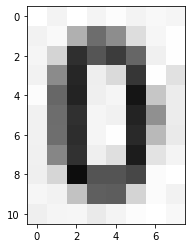

In [3]:
example = os.listdir(image_dir)[0]
img = plt.imread(image_dir+'/'+example)
plt.imshow(img)
plt.show()

In [4]:
with io.open(trans_dir+'/'+example[:-3]+'TXT', 'r',  encoding='utf8') as file:
    data = file.read()
print(data)

0


In [5]:
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

In [24]:
def process_texts(image_dir,trans_dir):
    lens = []
    letters = ''

    lines = []
    names = []
    
    all_files = os.listdir(trans_dir)
    for filename in os.listdir(image_dir):
        if filename[:-3]+'TXT' in all_files:
            name, ext = os.path.splitext(filename)
            txt_filepath = join(trans_dir, name + '.TXT')
            with open(txt_filepath, 'r',encoding='utf-8') as file:
                data = file.read()
                if len(data)==0:
                    continue
                lines.append(data)
                names.append(filename)
                lens.append(len(data))
                letters += data
    return names,lines,Counter(letters)

In [26]:
letters = set(cnt.keys())
letters = sorted(list(letters))
print('Символы train:', ' '.join(letters))

Символы train:   0 1 2 3 4 5 6 7 8 9 И К Н П и


In [27]:
def process_image(img):
    w, h,_ = img.shape
    
    new_w = 128
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h,_ = img.shape
    
    img = img.astype('float32')
    
    if w < 128:
        add_zeros = np.full((128-w, h,3), 255)
        img = np.concatenate((img, add_zeros))
        w, h,_ = img.shape
    
    if h < 1024:
        add_zeros = np.full((w, 1024-h,3), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h,_ = img.shape
        
    if h > 1024 or w > 128:
        dim = (1024,128)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)

    img = img / 255
    
    return img

In [28]:
def generate_data(lines,names,image_dir):
    data_images = []
    data_labels = []
    data_input_length = []
    data_label_length = []
    data_original_text = []
    data_original_image = []
    
    max_label_len = 0
    for line, name in tqdm.tqdm_notebook(zip(lines,names)):
        img = cv2.imread(image_dir+'/'+name)
        original_image = copy.deepcopy(img)
        img = process_image(img)
        try:
            label = text_to_labels(line)
        except:
            print('bad_label')
            continue
        data_images.append(img)
        data_labels.append(label)
        data_input_length.append(255)
        data_label_length.append(len(line))
        data_original_text.append(line)
        data_original_image.append(original_image)
        
        if len(line) > max_label_len:
            max_label_len = len(line)
        
    return data_images, data_labels, data_input_length, data_label_length, \
            data_original_text, data_original_image, max_label_len

In [29]:
lines_train = []
names_train = []

lines_val = []
names_val = []

#?if?
for num,(line, name) in enumerate(zip(lines,names)):
    if num % 15 == 0:
        lines_val.append(line)
        names_val.append(name)
    else:
        lines_train.append(line)
        names_train.append(name)

In [30]:
train_images, train_labels, train_input_length, train_label_length, train_original_text, train_original_image, \
        train_max_label_len = generate_data(lines_train, names_train, image_dir)

<ipython-input-28-67ee2440d525>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line, name in tqdm.tqdm_notebook(zip(lines,names)):


In [31]:
val_images, val_labels, val_input_length, val_label_length, val_original_text, val_original_image, \
        val_max_label_len = generate_data(lines_val, names_val, image_dir)

<ipython-input-28-67ee2440d525>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line, name in tqdm.tqdm_notebook(zip(lines,names)):


In [32]:
max_label_len = max(train_max_label_len,val_max_label_len)
print(max_label_len)

14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


КПП 772901001


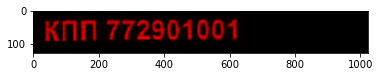

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


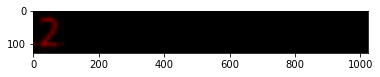

In [33]:
rnd = np.random.choice(range(len(train_images)),2)

for i in rnd:
    print(train_original_text[i])
    plt.imshow(train_images[i])
    plt.show()

In [34]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(letters))

val_padded_label = pad_sequences(val_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(letters))

In [35]:
train_padded_label.shape, val_padded_label.shape

((173, 14), (13, 14))

In [36]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

val_images = np.asarray(val_images)
val_input_length = np.asarray(val_input_length)
val_label_length = np.asarray(val_label_length)

In [37]:
train_images.shape

(173, 128, 1024, 3)

In [38]:
inputs = Input(shape=(128,1024,3))

conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(4, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(4, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

pool_4 = MaxPool2D(pool_size=(4, 1),padding='same')(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(4, 1),padding='same')(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

blstm_1 = Bidirectional(GRU(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(GRU(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(letters)+1, activation = 'softmax')(blstm_2)
act_model = Model(inputs=inputs, outputs=outputs)
    
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [39]:
act_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 1024, 3)]    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 1024, 64)     1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 512, 64)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 63, 512, 128)      73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 256, 128)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 256, 256)      295168    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 256, 256)     

In [40]:
batch_size = 20
epochs = 300

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics=['accuracy'])

os.makedirs('checkpoint', exist_ok=True)

filepath="checkpoint/model.hdf5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                              patience=5, min_lr=0.00001)

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint,es,reduce_lr]

history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([val_images, val_padded_label, val_input_length, val_label_length], [np.zeros(len(val_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/300

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to checkpoint\model.hdf5
9/9 - 257s - loss: 73.7906 - accuracy: 0.0000e+00 - val_loss: 7.1370 - val_accuracy: 0.0000e+00
Epoch 2/300

Epoch 00002: val_accuracy did not improve from 0.00000
9/9 - 261s - loss: 7.0701 - accuracy: 0.0000e+00 - val_loss: 4.3393 - val_accuracy: 0.0000e+00
Epoch 3/300

Epoch 00003: val_accuracy did not improve from 0.00000
9/9 - 265s - loss: 6.3200 - accuracy: 0.0000e+00 - val_loss: 4.0625 - val_accuracy: 0.0000e+00
Epoch 4/300

Epoch 00004: val_accuracy did not improve from 0.00000
9/9 - 268s - loss: 6.3233 - accuracy: 0.0000e+00 - val_loss: 4.6100 - val_accuracy: 0.0000e+00
Epoch 5/300

Epoch 00005: val_accuracy did not improve from 0.00000
9/9 - 269s - loss: 6.0056 - accuracy: 0.0000e+00 - val_loss: 4.8685 - val_accuracy: 0.0000e+00
Epoch 6/300

Epoch 00006: val_accuracy did not improve from 0.00000
9/9 - 269s - loss: 5.8172 - accuracy: 0.0000e+00 - val_loss: 4.1402 - val_ac

Epoch 51/300

Epoch 00051: val_accuracy improved from 0.53846 to 0.61538, saving model to checkpoint\model.hdf5
9/9 - 272s - loss: 0.7477 - accuracy: 0.8671 - val_loss: 1.3158 - val_accuracy: 0.6154
Epoch 52/300

Epoch 00052: val_accuracy did not improve from 0.61538
9/9 - 271s - loss: 0.6960 - accuracy: 0.8555 - val_loss: 1.5296 - val_accuracy: 0.5385
Epoch 53/300

Epoch 00053: val_accuracy did not improve from 0.61538
9/9 - 272s - loss: 0.6627 - accuracy: 0.8671 - val_loss: 1.2619 - val_accuracy: 0.5385
Epoch 54/300

Epoch 00054: val_accuracy did not improve from 0.61538
9/9 - 271s - loss: 0.6864 - accuracy: 0.8728 - val_loss: 1.4866 - val_accuracy: 0.5385
Epoch 55/300

Epoch 00055: val_accuracy did not improve from 0.61538
9/9 - 271s - loss: 0.6708 - accuracy: 0.8786 - val_loss: 1.6844 - val_accuracy: 0.5385
Epoch 56/300

Epoch 00056: val_accuracy improved from 0.61538 to 0.69231, saving model to checkpoint\model.hdf5
9/9 - 271s - loss: 0.6061 - accuracy: 0.8960 - val_loss: 1.3012 -

In [41]:
start = time.time()
act_model.load_weights(filepath)
prediction = act_model.predict(val_images)

decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)
end = time.time()
print(end-start)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
8.403263330459595


In [42]:
numCharErr = 0
numCharTotal = 0
numStringOK = 0
numStringTotal = 0

word_eds, word_true_lens = [], []

print('Ground truth -> Recognized')	
for i in range(len(out)):
    pred = ''
    for p in out[i]:
        if int(p) != -1:
            pred+=letters[int(p)]
    true = val_original_text[i]
    
    numStringOK += 1 if true == pred else 0
    numStringTotal += 1
    dist = editdistance.eval(pred, true)
    numCharErr += dist
    numCharTotal += len(true)
    
    pred_words = pred.split()
    true_words = true.split()
    word_eds.append(editdistance.eval(pred_words, true_words))
    word_true_lens.append(len(true_words))
    
    print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + true + '"', '->', '"' + pred + '"')

charErrorRate = numCharErr / numCharTotal
wordErrorRate = sum(word_eds) / sum(word_true_lens) 
stringAccuracy = numStringOK / numStringTotal
print('Character error rate: %f%%. Word error rate: %f%%. String accuracy: %f%%.' % \
      (charErrorRate*100.0,wordErrorRate*100.0, stringAccuracy*100.0))

Ground truth -> Recognized
[OK] "0" -> "0"
[OK] "1" -> "1"
[OK] "2" -> "2"
[ERR:1] "3" -> "2"
[OK] "4" -> "4"
[OK] "5" -> "5"
[OK] "5" -> "5"
[OK] "7" -> "7"
[OK] "8" -> "8"
[ERR:1] "9" -> "5"
[ERR:1] "И" -> "и"
[OK] "К" -> "К"
[ERR:1] "Н" -> "И"
Character error rate: 30.769231%. Word error rate: 30.769231%. String accuracy: 69.230769%.


In [46]:
names_test = names_val
test_image_dir = 'test/images'

test_images = []
names_test = []

for name in os.listdir(test_image_dir):
     img = cv2.imread(test_image_dir+'/'+name)
     img = process_image(img)
     test_images.append(img)
     names_test.append(name)
test_images = np.asarray(test_images)

start = time.time()

prediction =act_model.predict(test_images)
 
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

prediction = []
for i, x in enumerate(out):
    pred = ''
    for p in x:
        if int(p) != -1:
            pred+=letters[int(p)]
            
    prediction.append(pred)
end = time.time()
print(end - start)

84.25447797775269


In [47]:
len(prediction)

201

In [49]:
output_dir = 'predictions'
os.makedirs(output_dir, exist_ok=True)

for num, (name, line) in enumerate(zip(names_test, prediction)):
    with open(os.path.join(output_dir, name.replace('.jpg', '.TXT')), 'w',encoding='utf-8') as file:
        file.write(line)

In [59]:
prediction[-1]

'779712517'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


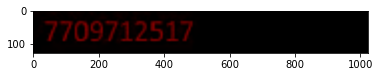

In [60]:
plt.imshow(img)